# Data Cleaning

In [72]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

# Enable inline mode for matplotlib so that Jupyter displays graphs
%matplotlib inline
data = pandas.read_csv("nba_data.csv")

One important note before we begin: Each row in our database is one teams per game stats in a single season.

When creating our original dataset, we stored the playoff result as a number. Since we want to predict it, I changed it to a string here.

In [73]:
data['Playoff result'].replace(0, "NP", inplace = True)  # No playoffs
data['Playoff result'].replace(1, "FR", inplace = True)  # Lost in first round
data['Playoff result'].replace(2, "SF", inplace = True)  # Lost in semi-finals
data['Playoff result'].replace(3, "CF", inplace = True)  # Lost in conference finals
data['Playoff result'].replace(4, "LF", inplace = True)  # Lost in finals
data['Playoff result'].replace(5, "WF", inplace = True)  # Won finals

Next, I changed a couple of the column names so all of our column names look similar.

In [74]:
data = data.rename(index=str, columns={"Games": "G", "Wins": "W", "Losses": "L","# of teams in league": "NUM_TEAMS", 
                                       "Playoff result": "Result", "Mean Age": "Age"})

There were two seasons in our dataset that had less than 82 games played. We removed them because we want all of our data to have a consistent sample size. Interestingly enough, in the 2012 season, the game scheduled to be played between the Indiana Pacers and Boston Celtics on April 16, 2013 was cancelled. This game was to take place in Boston the day after the Boston Marathon bombing. The game was cancelled because it was not considered significant. We decided to leave both of these seasons in, as the absence of one team shouldn't affect our data that much. 

In [75]:
data = data[data['G'] >= 81]

I wanted to add a column for win percent. This would allow us to combine both the wins and losses in to one column and do our analysis with fewer columns. Each season we will analyze has each team playing 82 games, so the win percent can be compared across seasons.

In [76]:
data["WIN_PCT"] = data['W'] / data['G']

Next, we had to figure out what columns to drop. We wanted to drop columns that had a high correlation and were combinations of other columns. Below is how we figured out which columns had high correlation.

In [77]:
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

s = upper.unstack()
so = s.sort_values(kind="quicksort")
so = so[:1175]

In [78]:
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(so)

WIN_PCT    NUM_TEAMS    0.000007
           Year         0.000011
MOV        Year         0.000054
SRS        NUM_TEAMS    0.000054
MOV        NUM_TEAMS    0.000059
L          NUM_TEAMS    0.000065
W          NUM_TEAMS    0.000065
SRS        Year         0.000066
L          Year         0.000097
W          Year         0.000097
OeFG%      TRB          0.000188
NRtg       NUM_TEAMS    0.000279
OeFG%      DRtg         0.000291
NRtg       Year         0.000303
PL         Year         0.000449
SOS        NUM_TEAMS    0.000600
PW         Year         0.000652
SOS        Year         0.000725
TRB        G            0.001923
FT%        MP           0.002041
OeFG%      G            0.002195
PW         NUM_TEAMS    0.002250
PL         NUM_TEAMS    0.002386
3PAr       FT%          0.002776
OeFG%      BLK          0.003913
OFT/FGA    DRtg         0.004130
OTOV%      DRtg         0.004725
PF         BLK          0.007253
MP         L            0.008122
AST        DRB          0.008231
WIN_PCT   

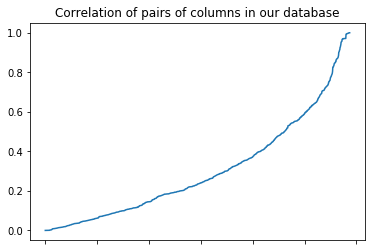

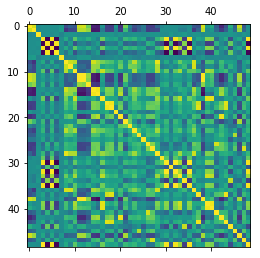

In [79]:
so.plot(title = 'Correlation of pairs of columns in our database')
plt.matshow(data.corr())
# Colored correlation matrix for our columns
plt.show()

We ended up running a few variations of our dataset in Darwin. We tried removing a few of the columns that were redundant or were combinations of multiple columns. For example, we removed the 2 pointers attempted and 2 pointers made columns but kept in the 2 pointer percentage. We found that Net Rating was a combination of offensive efficiency and defensive efficiency, so we removed Net Rating. We didn't drop these columns in this notebook, and instead took note of these columns for our other notebooks.

In [80]:
columns_to_drop = ['G', 'MP','W', 'L', 'PW', 'PL', 'NUM_TEAMS', '2PA', 'NRtg', "FG", '3P', '3PA', 'TOV', 'SRS', 'TRB']

# Data Exploration

In [81]:
# This is just a list of our columns that are numerical so we can look for interesting increases/decreases
cols = list(data.columns[3:])

Below, we are averaging each column for a given season and plotting the averages.

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


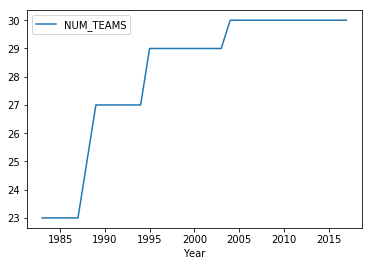

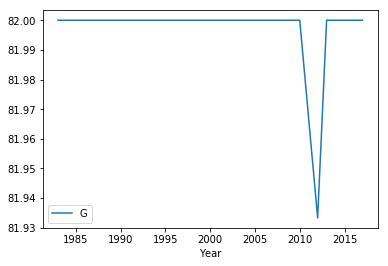

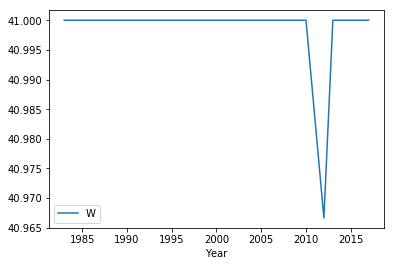

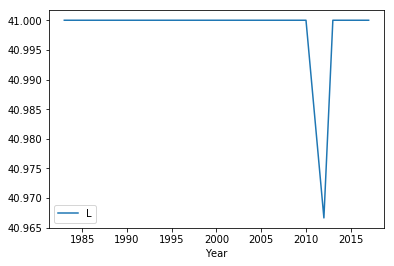

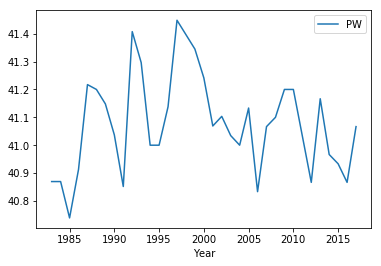

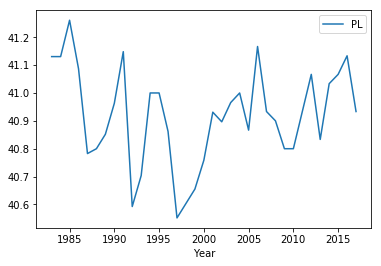

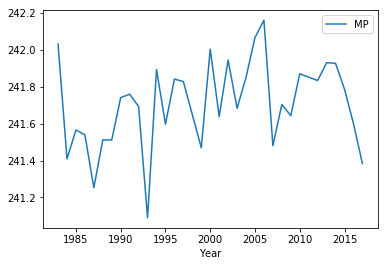

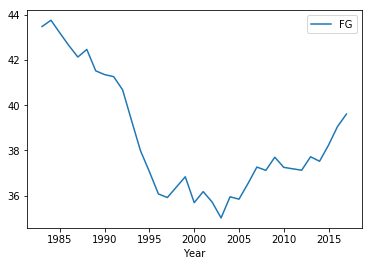

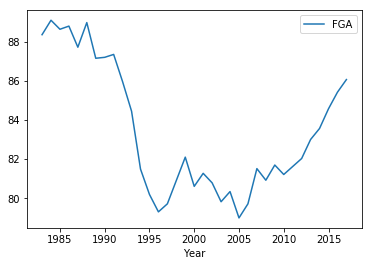

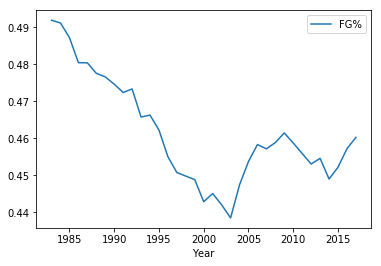

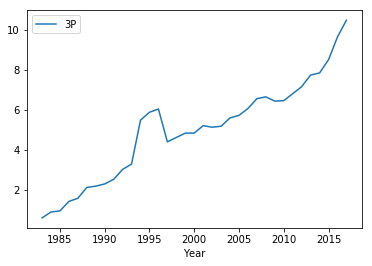

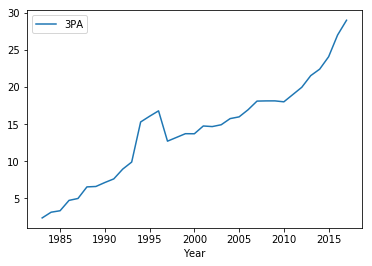

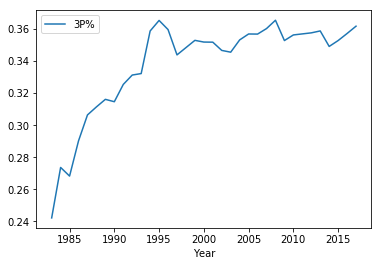

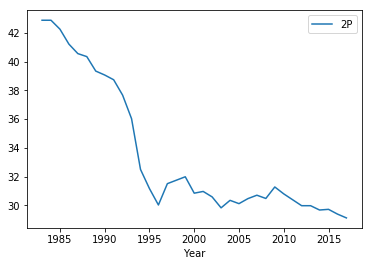

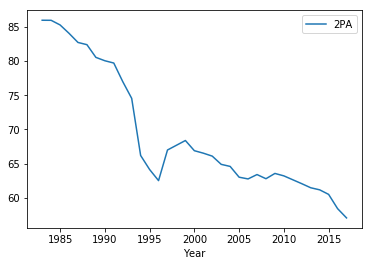

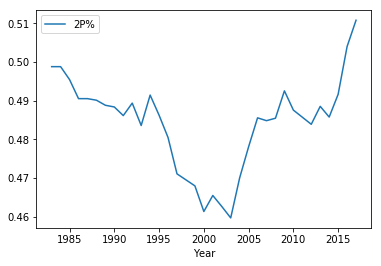

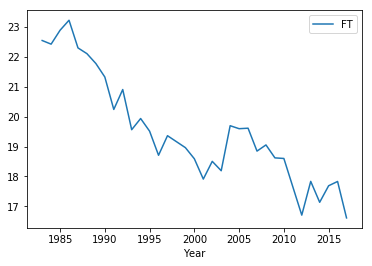

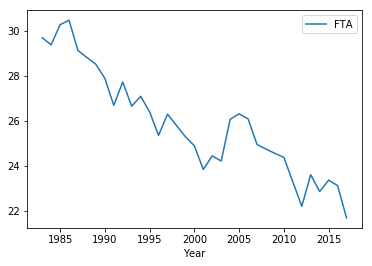

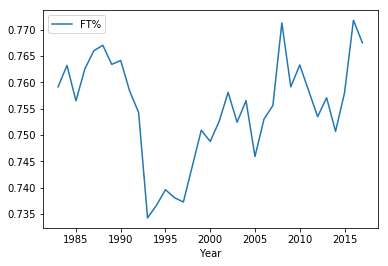

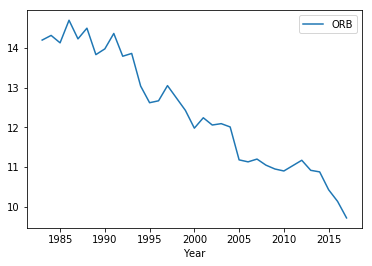

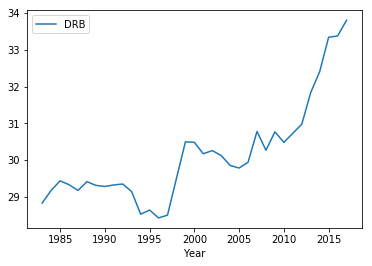

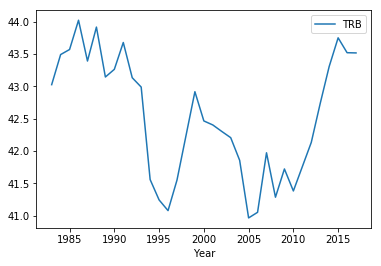

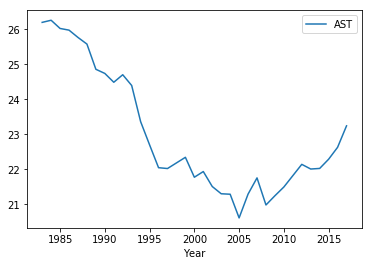

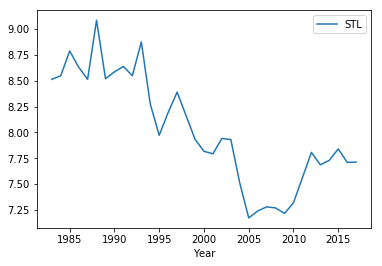

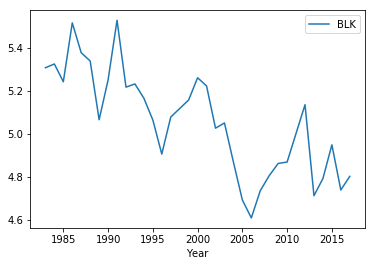

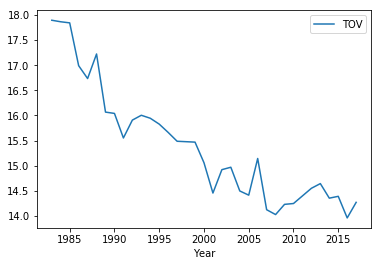

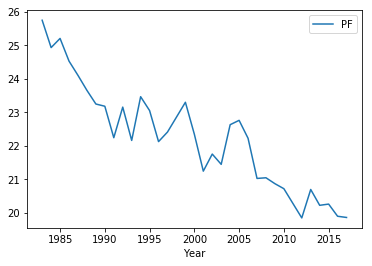

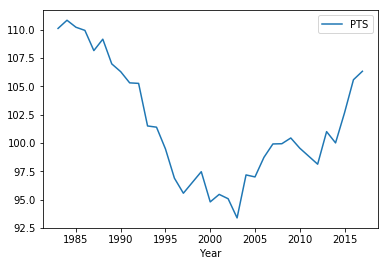

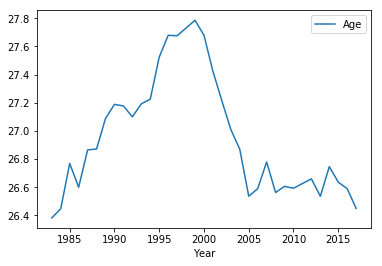

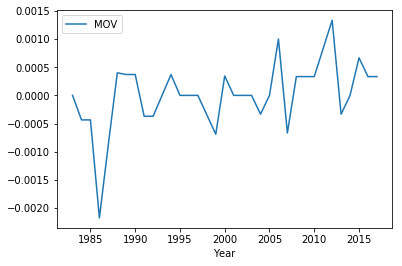

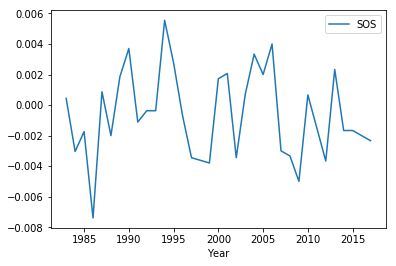

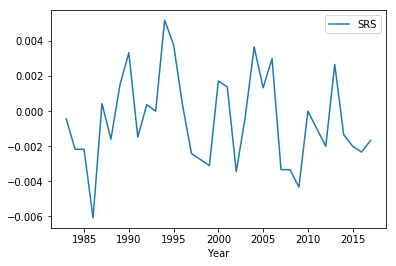

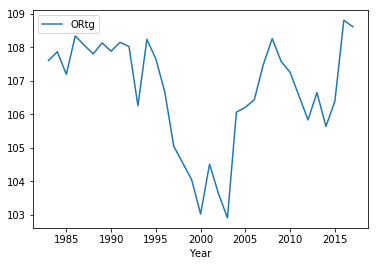

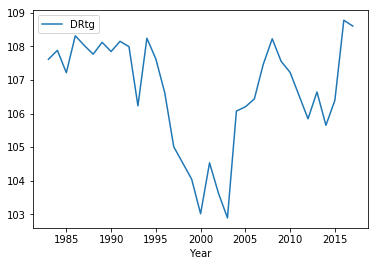

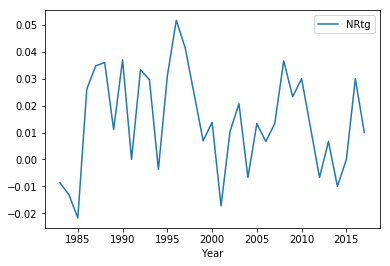

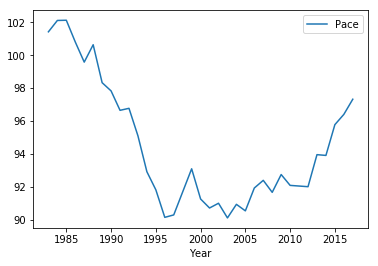

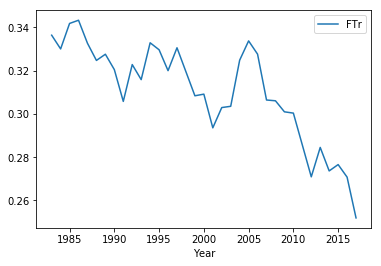

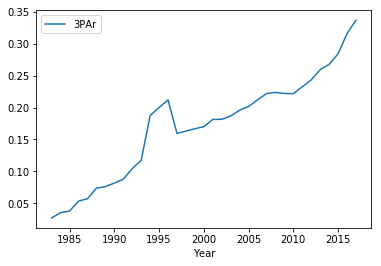

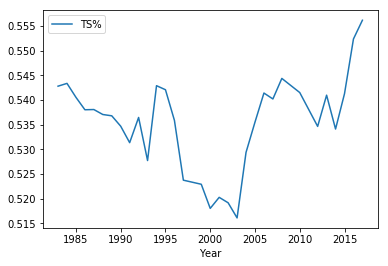

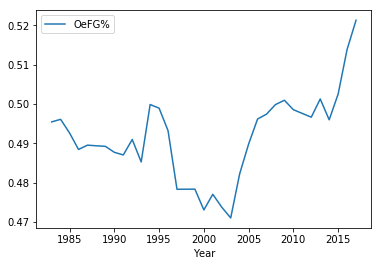

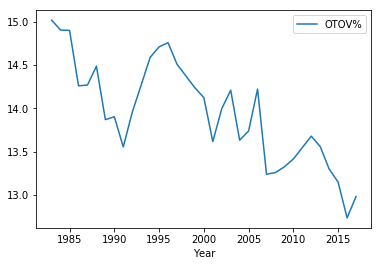

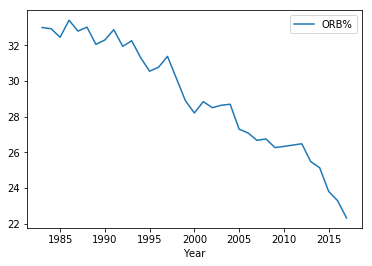

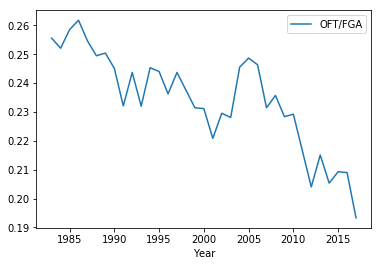

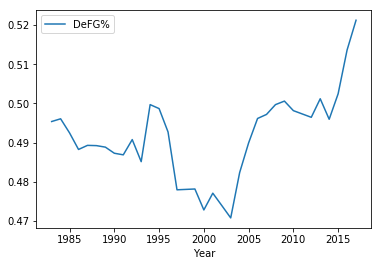

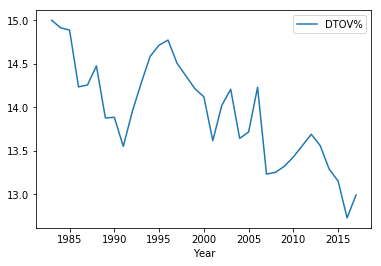

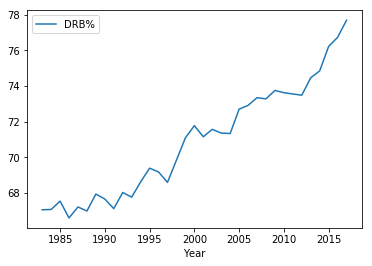

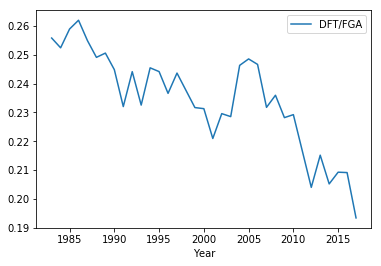

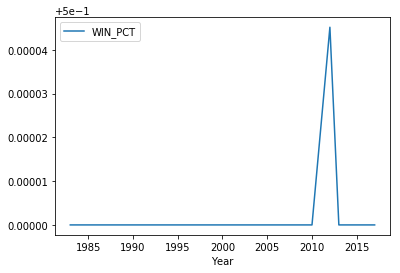

In [82]:
for i in cols:
    data.groupby('Year', as_index=False)[i].mean().set_index('Year').plot.line()

Average offensive rebounds have decreased over time and average defensive rebounds have increased over time. We have no clue why this is. Pace doesn't seem to correlate with either of these. It might be the case that as teams shoot more 3's, defensive rebounds increase and pace increases (within the last 10 years or so). This would explain the sharp increase in defensive rebounds in the last 10 years, and increase in pace over the same amount of time.

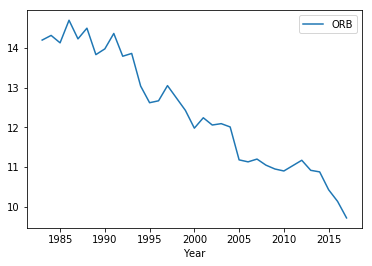

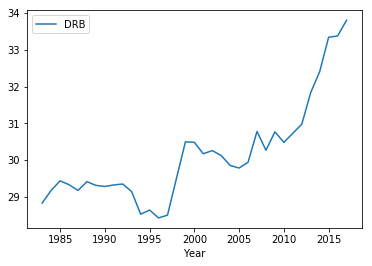

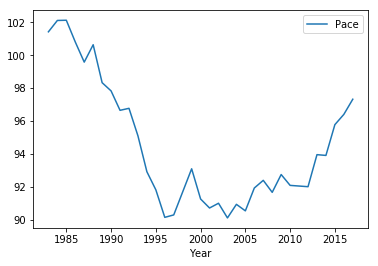

In [83]:
for i in ['ORB', 'DRB', 'Pace']:
    data.groupby('Year', as_index=False)[i].mean().set_index('Year').plot.line()

Continuing off the analysis I made above, I wanted to see if offensive rebound percentage and defensive rebound percentage had any relationships I could use to try to determine why Offensive rebounds had decreased and defensive rebounds had increased. I also looked at total rebounds. The average of total rebounds fluxuated what looked to be random between 44 and 41 rebounds per game, so I don't think the number of total rebounds had anything to do with the relatinship. As expected, the offensive rebound percentage has decreased and the defensive rebound percentage has increased.

One reason for this relationship could be that defensive rules in the 80's and 90's were very lax, and this could have led to a higher offensive rebound percentage. But there's no way to tell if this is the case.

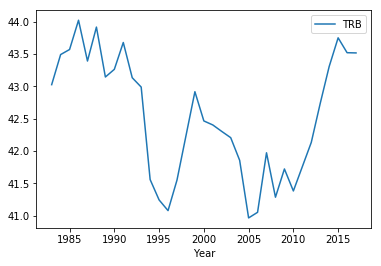

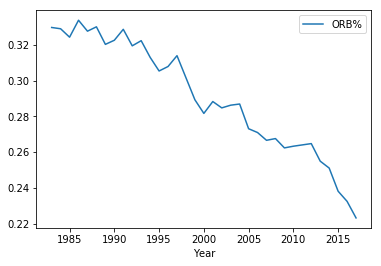

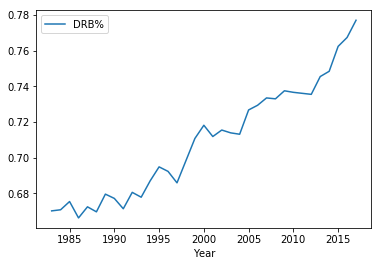

In [84]:
data['ORB%'] = data['ORB'] / (data['TRB'])
data['DRB%'] = data['DRB'] / (data['TRB'])
data.groupby('Year', as_index=False)['TRB'].mean().set_index('Year').plot.line()
data.groupby('Year', as_index=False)['ORB%'].mean().set_index('Year').plot.line()
data.groupby('Year', as_index=False)['DRB%'].mean().set_index('Year').plot.line()

We all know that the 3 point percentage has increased over time as players are taking and making more threes, but there was a 2 year period from 1994 to 1996 seasons that the three point percentage shot up suddenly. This is because the league moved the 3 point line in from 23'9" to 22' in attempt to increase the average scoring This change actually decreased average scoring, so the league moved the line back before the 1997 season. The 3 point average in 1997 was much higher than the average in 1994, so players got better at shooting threes while the line was closer to the basket. Decreasing the 3 point line also made the 2 point attempts decrease as well.

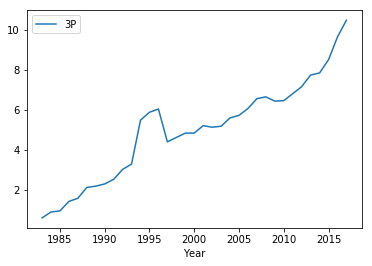

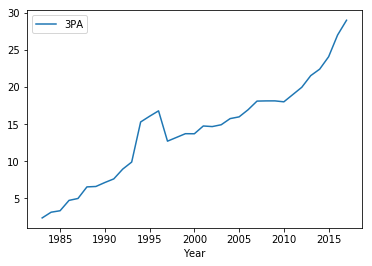

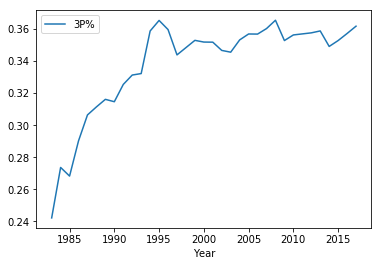

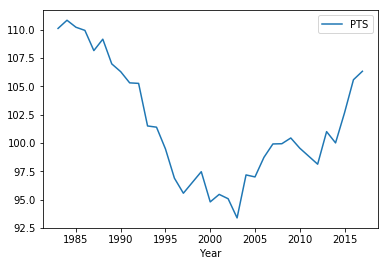

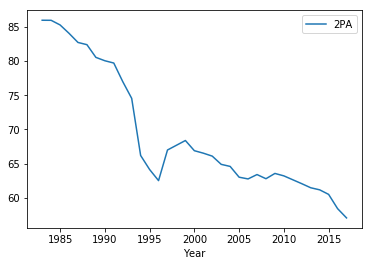

In [85]:
for i in ['3P', '3PA', '3P%', 'PTS', '2PA']:
    data.groupby('Year', as_index=False)[i].mean().set_index('Year').plot.line()